<a href="https://colab.research.google.com/github/johnmichaelt/cmsc_191_paper_neural_network/blob/main/Obesity_ANN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [119]:
import pandas
import tensorflow
import seaborn
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from keras.metrics import CategoricalAccuracy, Precision, Recall, AUC
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

# FILE READING AND FORMATTING
dataframe = pandas.read_csv("/content/ObesityDataSet_raw_and_data_sinthetic.csv", header=0)
dataframe = dataframe.dropna()

# TRANSFORM CLASS INPUT (TRANSPORTATION) INTO CLASSIFICATION COLUMNS
dummy_transportation = pandas.get_dummies(dataframe['MTRANS'],  drop_first=True)
dataframe = pandas.concat([dataframe, dummy_transportation], axis=1)
dataframe.drop('MTRANS', axis=1, inplace=True)
dataframe = dataframe[[c for c in dataframe if c not in ['NObeyesdad']] + [c for c in ['NObeyesdad'] if c in dataframe]]
dataframe = dataframe.sort_values(['NObeyesdad'])




In [90]:
# DATAFRAME -> NUMPY.NDARRAY
dataset = dataframe.values
group_segments = []
group_label = []
group_index = []
group_count = 0
string_segment = dataset[0][19]

# MULTICLASS COUNT & MULTICLASS LABEL COLLECTION
for item_index in range(len(dataset)):
  group_count += 1
  if dataset[item_index][19] == string_segment:
    continue
  else:
    group_label.append(string_segment)
    string_segment = dataset[item_index][19]
    group_segments.append(group_count)
    group_index.append(item_index)
    group_count = 0
group_index.append(len(dataset) - 1)
group_label.append(string_segment)
group_segments.append(group_count)

# IDENTIFICATION OF TRAINING-VALIDATION-TESTING (TVT) SET SIZES PER CLASS
training_count = [int(x) for x in (list(np.around([count * 0.6 for count in group_segments])))]
validation_count = [int(x) for x in (list(np.around([count * 0.2 for count in group_segments])))]
testing_count = [group_segments[x] - training_count[x] - validation_count[x] for x in range(len(group_segments))]

# INITIALIZE SETS (COLLECTIVE)
training_set = np.empty([1,20])
validation_set = np.empty([1,20])
testing_set = np.empty([1,20])




In [91]:
# DATASET SEPARATION PER CLASS FOR STRATIFIED SAMPLING
insufficient_group = dataset[0:273, :]
normal_group = dataset[273:560, :]
obesity_i_group = dataset[560:911, :]
obesity_ii_group = dataset[911:1208, :]
obesity_iii_group = dataset[1208:1532, :]
overweight_i_group = dataset[1532:1822, :]
overweight_ii_group = dataset[1822:2111, :]

# SHUFFLE CLASS, GET TVT SCALING PER CLASS, BUILD COLLECTIVE SET
def shuffle_list(list_group, category):
  for item in range(5):
    np.random.shuffle(list_group)
  validation_testing_boundary = training_count[category] + validation_count[category]
  testing_boundary = validation_testing_boundary + testing_count[category]
  training_list = list_group[0:training_count[category]]
  validation_list = list_group[training_count[category]:validation_testing_boundary]
  testing_list = list_group[validation_testing_boundary:testing_boundary]
  global training_set
  global validation_set
  global testing_set
  training_set = np.concatenate((training_set, training_list), axis=0)
  validation_set = np.concatenate((validation_set, validation_list), axis=0)
  testing_set = np.concatenate((testing_set, testing_list), axis=0)

shuffle_list(insufficient_group, 0)
shuffle_list(normal_group, 1)
shuffle_list(obesity_i_group, 2)
shuffle_list(obesity_ii_group, 3)
shuffle_list(obesity_iii_group, 4)
shuffle_list(overweight_i_group, 5)
shuffle_list(overweight_ii_group, 6)

# REMOVE GARBAGE VALUE FROM INITIALIZATION
training_set = np.delete(training_set, 0, 0)
validation_set = np.delete(validation_set, 0, 0)
testing_set = np.delete(testing_set, 0, 0)




In [92]:
# ASSEMBLE SEPARATED SETS FOR TRANSFORMATION
entire_dataset = np.concatenate((training_set, validation_set, testing_set), axis=0)

# NON-QUANTITATIVE DATA TRANSFORMATION TO QUANTITATIVE FORMAT (EXCEPT OBESITY CLASSIFICATION COLUMN)
for item in entire_dataset:
  for dataIndex in range(len(item)):
    if (dataIndex == 0 and item[dataIndex] == "Female") or item[dataIndex] == "yes" or ((dataIndex == 8 or dataIndex == 14) and item[dataIndex] == "Sometimes"):
      item[dataIndex] = 1
    elif ((dataIndex == 8 or dataIndex == 14) and item[dataIndex] == "Frequently"):
      item[dataIndex] = 2
    elif ((dataIndex == 8 or dataIndex == 14) and item[dataIndex] == "Always"):
      item[dataIndex] = 3
    elif item[dataIndex] == "no" or (dataIndex == 0 and item[dataIndex] == "Male"):
      item[dataIndex] = 0

training_count_total = sum(training_count)
validation_count_total = sum(validation_count)
testing_count_total = sum(testing_count)

# SPLIT ASSEMBLED MODIFIED SET TO TVT SETS
Train_set_random = entire_dataset[0:training_count_total,:]
Validation_set_random = entire_dataset[training_count_total:training_count_total + validation_count_total, :]
Test_set_random = entire_dataset[training_count_total + validation_count_total:, :]

# SHUFFLE TVT SETS
np.random.shuffle(Train_set_random)
np.random.shuffle(Validation_set_random)
np.random.shuffle(Test_set_random)

# X AND Y DATA ISOLATION FOR EACH SET IN TVT SETS
X_train = Train_set_random[:,0:19].astype('float32')
Y_train = Train_set_random[:,19]
X_validation = Validation_set_random[:,0:19].astype('float32')
Y_validation = Validation_set_random[:,19]
X_test = Test_set_random[:, 0:19].astype('float32')
Y_test = Test_set_random[:,19]

# DATA SCALING FOR EASIER DATA MANAGEMENT
scaler = StandardScaler()
# scaler = Normalizer()
X_train = scaler.fit_transform(X_train)
X_validation = scaler.transform(X_validation)
X_test = scaler.transform(X_test)

# Y DATA COLUMN TRANSFORMATION TO CATEGORICAL MANAGEABLE DATA
encoder = LabelEncoder()
encoder.fit(Y_train)
encoded_Y_train = encoder.transform(Y_train)
encoded_Y_validation = encoder.transform(Y_validation)
encoded_Y_test = encoder.transform(Y_test)

dummy_Y_train = np_utils.to_categorical(encoded_Y_train)
dummy_Y_validation = np_utils.to_categorical(encoded_Y_validation)
dummy_Y_test = np_utils.to_categorical(encoded_Y_test)




In [99]:
# MODEL CONSTRUCTION
BATCH_SIZE = 10
EPOCHS = 25

stop_model_learning = tensorflow.keras.callbacks.EarlyStopping(monitor="val_loss", verbose=0, mode="min", patience=10, restore_best_weights=True)

def main_model():
  model = Sequential()
  initializer = tensorflow.keras.initializers.RandomNormal(mean=0., stddev=1.)
  model.add(Dense(19, input_dim=19, activation='relu'))
  model.add(Dense(13, activation='relu'))
  model.add(Dense(7, activation='softmax', bias_initializer=initializer))
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[
    CategoricalAccuracy(name = 'accuracy'),
    Precision(name = 'precision'),
    Recall(name = 'recall'),
    AUC(name = 'aucroc', curve = 'ROC')
  ])
  return model

# INITIALIZATION OF MODEL
initial_model = main_model()
initial_model.save_weights('start_weights.model')

# FINAL MODEL TRAINING
obesity_model = main_model()
obesity_model.load_weights('start_weights.model')
records = obesity_model.fit(X_train, dummy_Y_train, verbose=1, epochs = EPOCHS, batch_size = BATCH_SIZE, validation_data=(X_validation, dummy_Y_validation))

Epoch 1/25
127/127 [==============================] - 2s 7ms/step - loss: 2.0215 - accuracy: 0.2378 - precision: 0.4211 - recall: 0.0190 - aucroc: 0.5774 - val_loss: 1.7566 - val_accuracy: 0.3223 - val_precision: 0.8750 - val_recall: 0.0166 - val_aucroc: 0.6890
Epoch 2/25
127/127 [==============================] - 0s 3ms/step - loss: 1.5461 - accuracy: 0.4021 - precision: 0.8723 - recall: 0.0648 - aucroc: 0.7922 - val_loss: 1.3414 - val_accuracy: 0.5047 - val_precision: 0.9412 - val_recall: 0.1896 - val_aucroc: 0.8682
Epoch 3/25
127/127 [==============================] - 0s 3ms/step - loss: 1.1869 - accuracy: 0.5545 - precision: 0.8728 - recall: 0.2330 - aucroc: 0.8975 - val_loss: 1.0903 - val_accuracy: 0.5900 - val_precision: 0.8346 - val_recall: 0.2512 - val_aucroc: 0.9170
Epoch 4/25
127/127 [==============================] - 0s 3ms/step - loss: 0.9811 - accuracy: 0.6414 - precision: 0.8592 - recall: 0.3712 - aucroc: 0.9304 - val_loss: 0.9511 - val_accuracy: 0.6351 - val_precision: 0

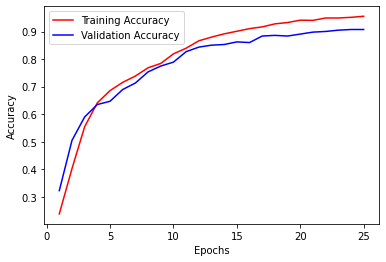

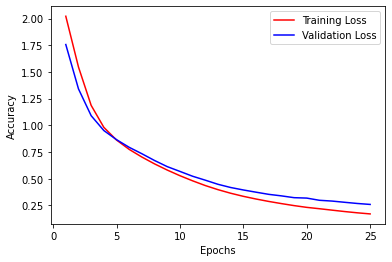

In [117]:
# TRAINING STATISTICS/GRAPH: ACCURACY
print("\n")
accuracy_train = records.history['accuracy']
accuracy_validation = records.history['val_accuracy']
plt.plot(range(1,EPOCHS + 1), accuracy_train, 'r', label="Training Accuracy")
plt.plot(range(1,EPOCHS + 1), accuracy_validation, 'b', label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()
print("\n")

# TRAINING STATISTICS/GRAPH: LOSS
loss_train = records.history['loss']
loss_validation = records.history['val_loss']
plt.plot(range(1,EPOCHS + 1), loss_train, 'r', label="Training Loss")
plt.plot(range(1,EPOCHS + 1), loss_validation, 'b', label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()
print("\n")

# MODEL PREDICTION FOR A GIVEN SET
# WITH MODEL STATISTICS
def predict_model(X_variable, Y_variable):
  model_prediction_test = obesity_model.predict(X_variable)
  model_statistics = obesity_model.evaluate(X_variable, Y_variable, batch_size = BATCH_SIZE)
  for item in range(len(model_statistics)):
    print(obesity_model.metrics_names[item], ": ", model_statistics[item])
  model_matrix = confusion_matrix(Y_variable.argmax(1), model_prediction_test.argmax(1))
  print(classification_report(Y_variable.argmax(1), model_prediction_test.argmax(1), digits = 3))
  show_confusion_matrix_diagram(model_matrix)

# CONFUSION MATRIX VISUALIZATION OF A GIVEN SET
def show_confusion_matrix_diagram(confusion_matrix):
  frame_matrix = pandas.DataFrame(confusion_matrix, index = group_label, columns = group_label)
  plt.figure(figsize = (8,5))
  seaborn.heatmap(frame_matrix, annot=True, fmt="d", cmap="YlGnBu")
  plt.xlabel('Predicted Level')
  plt.ylabel('Actual Level')




127/127 [==============================] - 0s 2ms/step - loss: 0.1566 - accuracy: 0.9613 - precision: 0.9688 - recall: 0.9573 - aucroc: 0.9989
loss :  0.15660707652568817
accuracy :  0.9612954258918762
precision :  0.9688249230384827
recall :  0.9573459625244141
aucroc :  0.9988535642623901
              precision    recall  f1-score   support

           0      0.959     0.988     0.973       164
           1      0.924     0.918     0.921       171
           2      0.995     0.948     0.971       212
           3      0.983     1.000     0.992       178
           4      1.000     0.995     0.997       193
           5      0.920     0.914     0.917       175
           6      0.938     0.965     0.952       173

    accuracy                          0.961      1266
   macro avg      0.960     0.961     0.960      1266
weighted avg      0.962     0.961     0.961      1266



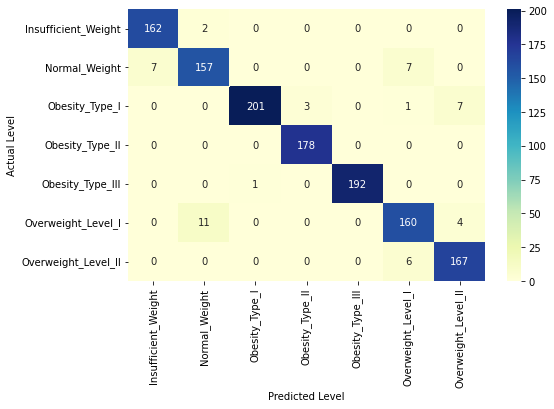

In [114]:
predict_model(X_train, dummy_Y_train)

43/43 [==============================] - 0s 2ms/step - loss: 0.2730 - accuracy: 0.8913 - precision: 0.9060 - recall: 0.8889 - aucroc: 0.9932
loss :  0.27298301458358765
accuracy :  0.8912529349327087
precision :  0.9060240983963013
recall :  0.8888888955116272
aucroc :  0.993195652961731
              precision    recall  f1-score   support

           0      0.836     0.944     0.887        54
           1      0.765     0.672     0.716        58
           2      0.984     0.899     0.939        69
           3      0.953     1.000     0.976        61
           4      1.000     1.000     1.000        65
           5      0.787     0.828     0.807        58
           6      0.879     0.879     0.879        58

    accuracy                          0.891       423
   macro avg      0.886     0.889     0.886       423
weighted avg      0.892     0.891     0.890       423



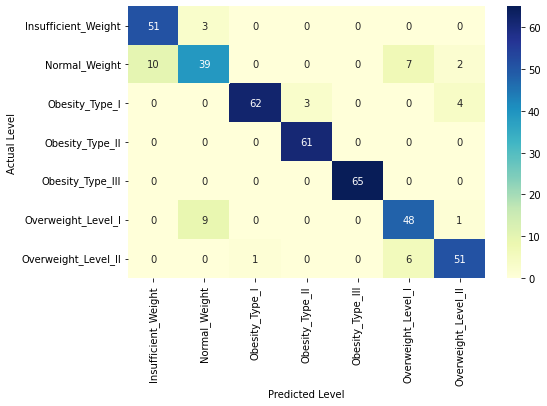

In [115]:
predict_model(X_test, dummy_Y_test)

In [101]:
for weight_set in obesity_model.get_weights():
  print(weight_set)
  print("\n\n")

[[ 4.24698082e-04 -1.12267822e-01 -1.75123457e-02 -9.01392251e-02
  -8.81558299e-01 -1.29633933e-01  3.01542073e-01 -3.09692055e-01
   1.90711677e-01  1.12685427e-01  2.57063329e-01 -7.73971602e-02
   1.87296912e-01  6.86630547e-01 -3.90543938e-01 -2.92124450e-01
  -3.93352687e-01  1.35343552e-01 -3.12387884e-01]
 [ 1.33299202e-01  3.13584477e-01 -1.16893888e-01  1.65418819e-01
   4.45969552e-01 -9.55700651e-02  6.17792569e-02  1.81112915e-01
   1.12643056e-01 -2.03582779e-01  4.60183173e-02 -7.13191926e-02
  -1.64726406e-01  3.23723465e-01  4.77318645e-01  2.17581317e-01
  -6.05077863e-01  1.26877353e-01  1.58120662e-01]
 [ 7.53523648e-01  1.04484342e-01  8.06041718e-01 -1.09127015e-01
  -3.39475900e-01  2.00767189e-01 -1.98756367e-01 -3.80701721e-01
   1.96040690e-01 -1.87522098e-01  3.43933046e-01 -7.61110783e-02
  -2.24404097e-01 -3.05090070e-01 -2.04284325e-01  5.80582857e-01
   3.62995297e-01 -2.14801475e-01  6.13824487e-01]
 [-1.69208884e+00 -8.48463297e-01 -1.23592591e+00  1.23